In [36]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import h5py
import pandas as pd
import numpy as np
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [37]:
f = h5py.File('./data/processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth.z', 'r')
treeArray = f['t_allpar_new'][()]

In [38]:
features = ['j1_ptrel','j1_etarot','j1_phirot','j1_erel','j1_deltaR','j1_pdgid','j_index']
labels = ['j_g','j_q','j_w','j_z','j_t','j_index']

In [39]:
features_df = pd.DataFrame(treeArray,columns=list(set(features)))
labels_df = pd.DataFrame(treeArray,columns=list(set(labels)))
df = pd.concat([features_df,labels_df],axis=1)
df = df.drop_duplicates()

In [40]:
MaxParticles = 20
l1Reg = 0.0001
# Convert to nparray
labels_df = labels_df.drop_duplicates()
features_val = features_df.drop(['j_index'],axis=1).values
labels_val = labels_df.drop(['j_index'],axis=1).values

features_2dval = np.zeros((len(labels_df), MaxParticles, len(features) - 1))
for i in range(0, len(labels_df)):
    features_df_i = features_df[features_df['j_index'] == labels_df['j_index'].iloc[i]]
    index_values = features_df_i.index.values

    features_val_i = features_val[np.array(index_values), :]
    nParticles = len(features_val_i)
    features_val_i = features_val_i[features_val_i[:, 0].argsort()[::-1]]  # sort descending by first value (ptrel, usually)
    
    if nParticles > MaxParticles:
        features_val_i = features_val_i[0:MaxParticles, :]
    else:
        features_val_i = np.concatenate([features_val_i, np.zeros((MaxParticles - nParticles, len(features) - 1))])
    features_2dval[i, :, :] = features_val_i

features_val = features_2dval

In [41]:
X_train_val, X_test, y_train_val, y_test = train_test_split(features_val, labels_val, test_size=0.2,random_state=42)

In [42]:
# lstmConfig = {
#     units = 72, activation='tanh', recurrent_activation='sigmoid', use_bias=True,
#     kernel_initializer='lecun_uniform', recurrent_initializer='orthogonal',
#     bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=l1(l1Reg),
#     recurrent_regularizer=l1(0.001), bias_regularizer=None, activity_regularizer=None,
#     kernel_constraint=None, recurrent_constraint=None, bias_constraint=None,
#     dropout=0.001, recurrent_dropout=0.00001, implementation=2, return_sequences=True,
#     return_state=False, go_backwards=False, stateful=False, time_major=False,
#     unroll=False
# }

### LSTM - Conv1D

In [43]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(20,6)))
model.add(layers.Conv1D(filters=32, kernel_size=2, strides=1, padding='same',
                        kernel_initializer='he_normal', use_bias=True, name='conv1_relu_1',
                        activation = 'relu', kernel_regularizer=l1(l1Reg)))
model.add(layers.Conv1D(filters=16, kernel_size=4, strides=1, padding='same',
                        kernel_initializer='he_normal', use_bias=True, name='conv1_relu_2',
                        activation = 'relu', kernel_regularizer=l1(l1Reg)))
model.add(layers.LSTM(units = 72, activation='tanh', recurrent_activation='sigmoid', use_bias=True,
                      kernel_initializer='lecun_uniform', recurrent_initializer='orthogonal',
                      bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=l1(l1Reg),
                      recurrent_regularizer=l1(0.001), bias_regularizer=None, activity_regularizer=None,
                      kernel_constraint=None, recurrent_constraint=None, bias_constraint=None,
                      dropout=0.001, recurrent_dropout=0.00001,return_sequences=True,name='lstm'))
model.add(layers.Flatten())
model.add(layers.Dense(96, activation='relu', kernel_initializer='lecun_uniform', 
              name='fc_relu1', kernel_regularizer=l1(l1Reg)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(96, activation='relu', kernel_initializer='lecun_uniform', 
              name='fc_relu2', kernel_regularizer=l1(l1Reg)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(5, activation='softmax', kernel_initializer='lecun_uniform', 
                        name='output_softmax', kernel_regularizer=l1(l1Reg)))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_relu_1 (Conv1D)        (None, 20, 32)            416       
_________________________________________________________________
conv1_relu_2 (Conv1D)        (None, 20, 16)            2064      
_________________________________________________________________
lstm (LSTM)                  (None, 20, 72)            25632     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1440)              0         
_________________________________________________________________
fc_relu1 (Dense)             (None, 96)                138336    
_________________________________________________________________
dropout_2 (Dropout)          (None, 96)                0         
_________________________________________________________________
fc_relu2 (Dense)             (None, 96)               

In [44]:
learningRate = 1e-4
adam = Adam(lr=learningRate)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [45]:
history = model.fit(X_train_val, y_train_val, epochs=30, batch_size=1024, validation_split=0.25, shuffle=True)

Train on 14889 samples, validate on 4963 samples
Epoch 1/30
14889/14889 [==============================] - 15s 1ms/sample - loss: 2.1165 - accuracy: 0.7718 - val_loss: 1.6567 - val_accuracy: 0.8072
Epoch 2/30
14889/14889 [==============================] - 4s 238us/sample - loss: 1.4846 - accuracy: 0.8395 - val_loss: 1.2801 - val_accuracy: 0.8688
Epoch 3/30
14889/14889 [==============================] - 4s 236us/sample - loss: 1.1681 - accuracy: 0.8823 - val_loss: 1.0244 - val_accuracy: 0.8928
Epoch 4/30
14889/14889 [==============================] - 3s 233us/sample - loss: 0.9541 - accuracy: 0.8929 - val_loss: 0.8524 - val_accuracy: 0.9053
Epoch 5/30
14889/14889 [==============================] - 3s 230us/sample - loss: 0.8073 - accuracy: 0.8991 - val_loss: 0.7364 - val_accuracy: 0.9069
Epoch 6/30
14889/14889 [==============================] - 3s 231us/sample - loss: 0.7080 - accuracy: 0.9014 - val_loss: 0.6585 - val_accuracy: 0.9079
Epoch 7/30
14889/14889 [============================

Text(0.25, 0.9, 'LSTM')

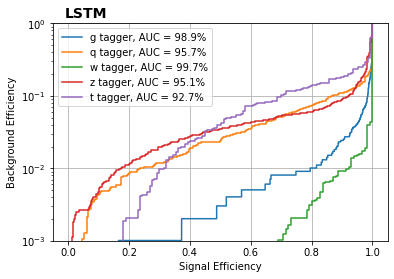

In [46]:
# ROC Plot

if 'j_index' in labels: labels.remove('j_index')

predict_test = model.predict(X_test)

df = pd.DataFrame()

fpr = {}
tpr = {}
auc1 = {}

plt.figure()       
for i, label in enumerate(labels):
    df[label] = y_test[:,i]
    df[label + '_pred'] = predict_test[:,i]

    fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

    auc1[label] = auc(fpr[label], tpr[label])

    plt.plot(tpr[label],fpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
plt.semilogy()
plt.xlabel("Signal Efficiency")
plt.ylabel("Background Efficiency")
plt.ylim(0.001,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.figtext(0.25, 0.90,'LSTM',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)

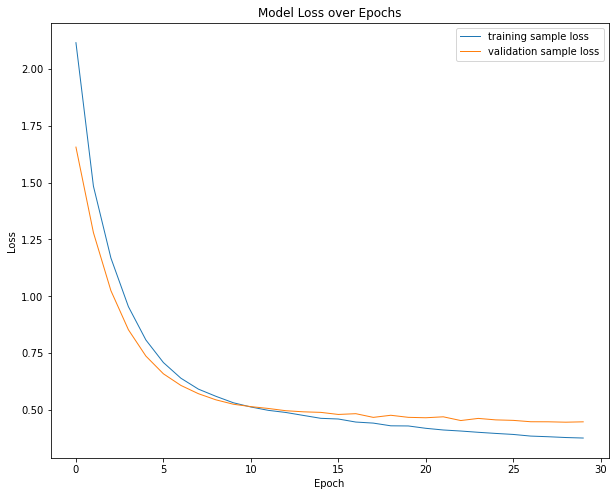

In [47]:
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], linewidth=1)
plt.plot(history.history['val_loss'], linewidth=1)
plt.title('Model Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training sample loss','validation sample loss'])
#plt.savefig('Learning_curve.pdf')
plt.show()
plt.close()

### LSTM only

In [48]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(20,6)))

model.add(layers.LSTM(units = 72, activation='tanh', recurrent_activation='sigmoid', use_bias=True,
                      kernel_initializer='lecun_uniform', recurrent_initializer='orthogonal',
                      bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=l1(l1Reg),
                      recurrent_regularizer=l1(0.001), bias_regularizer=None, activity_regularizer=None,
                      kernel_constraint=None, recurrent_constraint=None, bias_constraint=None,
                      dropout=0.001, recurrent_dropout=0.00001,return_sequences=True,name='lstm'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform', 
              name='fc_relu1', kernel_regularizer=l1(l1Reg)))
model.add(layers.Dense(128, activation='relu', kernel_initializer='lecun_uniform', 
              name='fc_relu2', kernel_regularizer=l1(l1Reg)))
model.add(layers.Dense(5, activation='softmax', kernel_initializer='lecun_uniform', 
                        name='output_softmax', kernel_regularizer=l1(l1Reg)))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 72)            22752     
_________________________________________________________________
flatten_3 (Flatten)          (None, 1440)              0         
_________________________________________________________________
fc_relu1 (Dense)             (None, 128)               184448    
_________________________________________________________________
fc_relu2 (Dense)             (None, 128)               16512     
_________________________________________________________________
output_softmax (Dense)       (None, 5)                 645       
Total params: 224,357
Trainable params: 224,357
Non-trainable params: 0
_________________________________________________________________


In [49]:
learningRate = 5e-5
adam = Adam(lr=learningRate)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_val, y_train_val, epochs=100, batch_size=1024, validation_split=0.25, shuffle=True)

Train on 14889 samples, validate on 4963 samples
Epoch 1/100
14889/14889 [==============================] - 11s 767us/sample - loss: 2.1341 - accuracy: 0.7687 - val_loss: 1.7093 - val_accuracy: 0.8072
Epoch 2/100
14889/14889 [==============================] - 2s 153us/sample - loss: 1.5304 - accuracy: 0.8272 - val_loss: 1.3502 - val_accuracy: 0.8416
Epoch 3/100
14889/14889 [==============================] - 2s 155us/sample - loss: 1.2406 - accuracy: 0.8485 - val_loss: 1.1175 - val_accuracy: 0.8584
Epoch 4/100
14889/14889 [==============================] - 2s 152us/sample - loss: 1.0438 - accuracy: 0.8575 - val_loss: 0.9605 - val_accuracy: 0.8557
Epoch 5/100
14889/14889 [==============================] - 2s 151us/sample - loss: 0.9047 - accuracy: 0.8570 - val_loss: 0.8470 - val_accuracy: 0.8575
Epoch 6/100
14889/14889 [==============================] - 2s 160us/sample - loss: 0.8068 - accuracy: 0.8569 - val_loss: 0.7624 - val_accuracy: 0.8577
Epoch 7/100
14889/14889 [===================

14889/14889 [==============================] - 3s 177us/sample - loss: 0.2068 - accuracy: 0.9441 - val_loss: 0.1728 - val_accuracy: 0.9569
Epoch 55/100
14889/14889 [==============================] - 3s 171us/sample - loss: 0.1674 - accuracy: 0.9610 - val_loss: 0.1796 - val_accuracy: 0.9506
Epoch 56/100
14889/14889 [==============================] - 3s 179us/sample - loss: 0.1637 - accuracy: 0.9610 - val_loss: 0.1592 - val_accuracy: 0.9643
Epoch 57/100
14889/14889 [==============================] - 3s 175us/sample - loss: 0.1556 - accuracy: 0.9651 - val_loss: 0.1818 - val_accuracy: 0.9462
Epoch 58/100
14889/14889 [==============================] - 3s 171us/sample - loss: 0.1563 - accuracy: 0.9654 - val_loss: 0.1597 - val_accuracy: 0.9668
Epoch 59/100
14889/14889 [==============================] - 3s 178us/sample - loss: 0.1489 - accuracy: 0.9668 - val_loss: 0.1515 - val_accuracy: 0.9702
Epoch 60/100
14889/14889 [==============================] - 3s 181us/sample - loss: 0.1870 - accuracy

Text(0.25, 0.9, 'LSTM only')

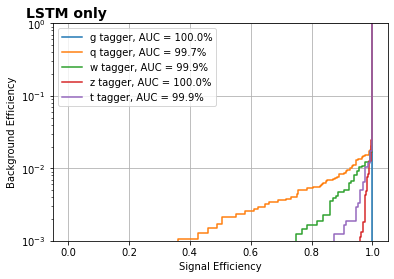

In [50]:
# ROC Plot

if 'j_index' in labels: labels.remove('j_index')

predict_test = model.predict(X_test)

df = pd.DataFrame()

fpr = {}
tpr = {}
auc1 = {}

plt.figure()       
for i, label in enumerate(labels):
    df[label] = y_test[:,i]
    df[label + '_pred'] = predict_test[:,i]

    fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

    auc1[label] = auc(fpr[label], tpr[label])

    plt.plot(tpr[label],fpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
plt.semilogy()
plt.xlabel("Signal Efficiency")
plt.ylabel("Background Efficiency")
plt.ylim(0.001,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.figtext(0.25, 0.90,'LSTM only',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)

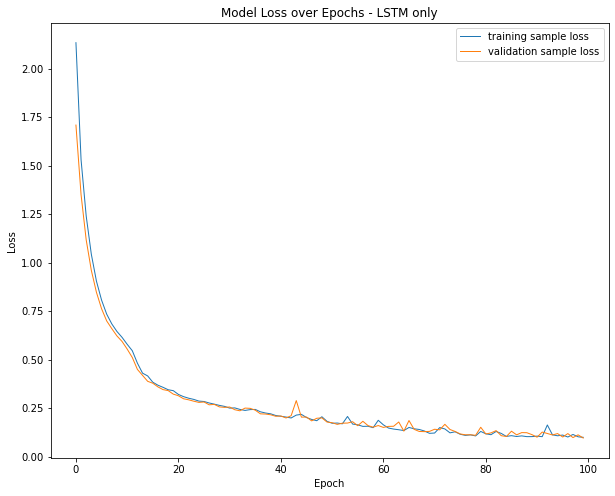

In [51]:
# Loss

plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], linewidth=1)
plt.plot(history.history['val_loss'], linewidth=1)
plt.title('Model Loss over Epochs - LSTM only')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training sample loss','validation sample loss'])
#plt.savefig('Learning_curve.pdf')
plt.show()
plt.close()

## try ***_0.z file

In [52]:
f0 = h5py.File('./data/processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth_0.z', 'r')
treeArray = f['t_allpar_new'][()]
features = ['j1_ptrel','j1_etarot','j1_phirot','j1_erel','j1_deltaR','j1_pdgid','j_index']
labels = ['j_g','j_q','j_w','j_z','j_t','j_index']
features_df0 = pd.DataFrame(treeArray,columns=list(set(features)))
labels_df0 = pd.DataFrame(treeArray,columns=list(set(labels)))
df0 = pd.concat([features_df0,labels_df0],axis=1)
df0 = df.drop_duplicates()

In [53]:
MaxParticles = 20
l1Reg = 0.0001
# Convert to nparray
labels_df0 = labels_df0.drop_duplicates()
features_val0 = features_df0.drop(['j_index'],axis=1).values
labels_val0 = labels_df0.drop(['j_index'],axis=1).values

features_2dval0 = np.zeros((len(labels_df0), MaxParticles, len(features) - 1))
for i in range(0, len(labels_df0)):
    features_df0_i = features_df0[features_df0['j_index'] == labels_df0['j_index'].iloc[i]]
    index_values0 = features_df0_i.index.values

    features_val0_i = features_val0[np.array(index_values0), :]
    nParticles0 = len(features_val0_i)
    features_val0_i = features_val0_i[features_val0_i[:, 0].argsort()[::-1]]  # sort descending by first value (ptrel, usually)
    
    if nParticles0 > MaxParticles:
        features_val0_i = features_val0_i[0:MaxParticles, :]
    else:
        features_val0_i = np.concatenate([features_val0_i, np.zeros((MaxParticles - nParticles0, len(features) - 1))])
    features_2dval0[i, :, :] = features_val0_i

features_val0 = features_2dval0

In [54]:
features_val0.shape

(24816, 20, 6)

Text(0.25, 0.9, 'LSTM only_fixedData')

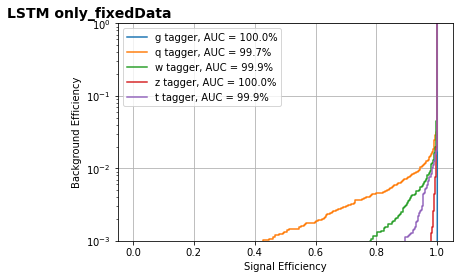

In [55]:
# ROC Plot

if 'j_index' in labels: labels.remove('j_index')

predict_test = model.predict(features_val0)

df0 = pd.DataFrame()

fpr = {}
tpr = {}
auc1 = {}

plt.figure()       
for i, label in enumerate(labels):
    df0[label] = labels_val0[:,i]
    df0[label + '_pred'] = predict_test[:,i]

    fpr[label], tpr[label], threshold = roc_curve(df0[label],df0[label+'_pred'])

    auc1[label] = auc(fpr[label], tpr[label])

    plt.plot(tpr[label],fpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
plt.semilogy()
plt.xlabel("Signal Efficiency")
plt.ylabel("Background Efficiency")
plt.ylim(0.001,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.figtext(0.25, 0.90,'LSTM only_fixedData',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)

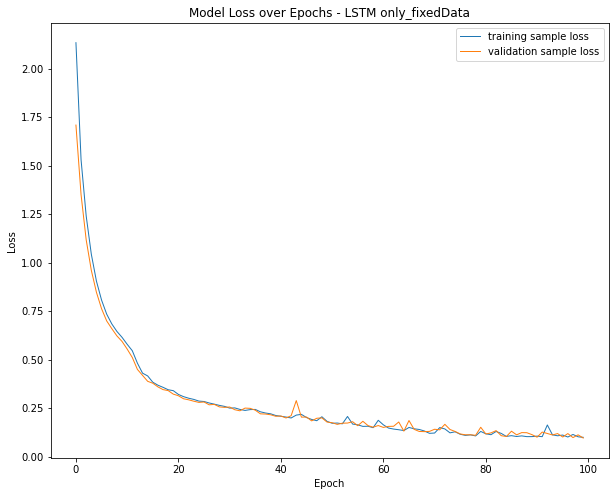

In [56]:
# Loss

plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], linewidth=1)
plt.plot(history.history['val_loss'], linewidth=1)
plt.title('Model Loss over Epochs - LSTM only_fixedData')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training sample loss','validation sample loss'])
#plt.savefig('Learning_curve.pdf')
plt.show()
plt.close()